# tSZ cross Galaxies for multiple samples

## Initializing session

In [16]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math

font = {'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})


common_settings = {
                   # LambdaCDM parameters
                   'H0':67.556,
                   'omega_b':0.022032,
                   'omega_cdm':0.12038,
                   # 'sigma8': 0.831,
                   'ln10^{10}A_s': 3.047,
                   'n_s': 0.9665,
                   'tau_reio':0.0925,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246,
}


import os 
path_to_class_sz = os.environ['PATH_TO_CLASS_SZ_DATA']

In [7]:
path_to_class_sz

'/Users/boris/class_sz_data_directory'

## Initializing HOD parameters

In [8]:
# best-fit from Kusiak et al. https://arxiv.org/pdf/2203.12583.pdf

HOD_0 = {
'sigma_log10M_HOD_ngal_0': 0.68660116,
'alpha_s_HOD_ngal_0':    1.3039425,
'M1_prime_HOD_ngal_0': 10**12.701308, # Msun/h
'M_min_HOD_ngal_0': 10**11.795964, # Msun/h
'M0_HOD_ngal_0' :0,
'x_out_truncated_nfw_profile_satellite_galaxies_ngal_0':  1.0868995,
'f_cen_HOD_ngal_0' : 1., 
}

HOD_1 = {
'alpha_s_HOD_ngal_1':  1.3023026,
'sigma_log10M_HOD_ngal_1':0.97260617,
'M1_prime_HOD_ngal_1': 10**13.440975,
'M_min_HOD_ngal_1':10**13.127660,
'M0_HOD_ngal_1' :0,
'x_out_truncated_nfw_profile_satellite_galaxies_ngal_1':2.7461961,
'f_cen_HOD_ngal_1' : 1., 
}

HOD_2 = {

'sigma_log10M_HOD_ngal_2' :  0.40339510,
'alpha_s_HOD_ngal_2' :   1.6292653,
'M1_prime_HOD_ngal_2':  10** 13.518607,
'M_min_HOD_ngal_2': 10** 12.707242,
'M0_HOD_ngal_2' :0,
'x_out_truncated_nfw_profile_satellite_galaxies_ngal_2': 0.18379845,
'f_cen_HOD_ngal_2' : 1., 
}

HOD_common = {
'z_min': 0.005,
'z_max': 4,
'M_min': 7.0e8,
'M_max': 3.5e15,
    
'dlogell': 0.2,
'ell_max': 6000.0,
'ell_min': 2.0,
    

'redshift_epsabs': 1.0e-40,
'redshift_epsrel': 0.0001,
'mass_epsabs': 1.0e-40,
'mass_epsrel': 0.001,
# 'ndim_masses': 150,
'ndim_redshifts': 50,

'hm_consistency': 1,

'delta for galaxies': "200c",
'delta for matter density': "200c",
'mass function': 'T08M200c',
'concentration parameter': 'B13' ,
    
'M0 equal M_min (HOD)':'no',
'x_out_truncated_nfw_profile': 1.0,
}


## Initializing pressure profile parameters

In [9]:
# Battaglia 2012 pressure profile 
b12 = {  
    'pressure profile': 'B12',
    'units for tSZ spectrum': 'dimensionless',
    'x_outSZ': 4.,
    # 'truncate_gas_pressure_wrt_rvir': 0, 

    'use_fft_for_profiles_transform' : 1,
    'N_samp_fftw' : 1024,
    'x_min_gas_pressure_fftw' : 1e-5,
    'x_max_gas_pressure_fftw' : 1e5,
    
    'pressure_profile_epsrel': 1e-3,
    'pressure_profile_epsabs': 1e-40,
    
    'n_z_pressure_profile': 80,
    'n_m_pressure_profile' : 80,
    'n_l_pressure_profile' : 80,

    'l_min_gas_pressure_profile' :  1.e-2,
    'l_max_gas_pressure_profile' :  5.e4,      
    
    }

## Saving dndz files in correct format

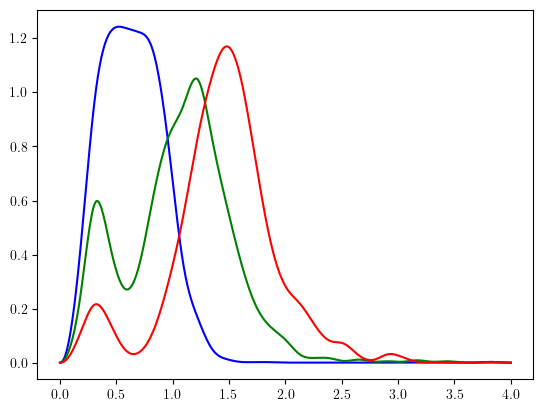

In [10]:
import numpy as np
zuw, dnblue, dngreen, dnred = np.loadtxt(path_to_class_sz + '/class_sz/class-sz/class_sz_auxiliary_files/includes/normalised_dndz_cosmos.txt',unpack=True)
plt.plot(zuw,dnblue,c='blue')
plt.plot(zuw,dngreen,c='green')
plt.plot(zuw,dnred,c='red')

In [11]:
# we save the dndz in seprate files, that's how we do. 
# np.savetxt(path_to_class_sz + '/class_sz/class-sz/class_sz_auxiliary_files/includes/normalised_dndz_cosmos_0.txt',np.c_[zuw,dnblue])
np.savetxt(path_to_class_sz + '/class_sz/class-sz/class_sz_auxiliary_files/includes/normalised_dndz_cosmos_1.txt',np.c_[zuw,dngreen])
np.savetxt(path_to_class_sz + '/class_sz/class-sz/class_sz_auxiliary_files/includes/normalised_dndz_cosmos_2.txt',np.c_[zuw,dnred])

In [12]:
path_to_class_sz

'/Users/boris/class_sz_data_directory'

## Halo model cross-power spectra

## Compute

In [13]:
%%time
M = Class()
M.set(common_settings)
M.set(HOD_common)
M.set(HOD_0) #ngal_0
M.set(HOD_1) #ngal_1
M.set(HOD_2) #ngal_2
M.set(b12) # Battaglia pressure profile

M.set({
'output' : 'galn_tsz_1h, galn_tsz_2h', # lensmagn_tsz also available 
'galaxy_samples_list_num' : 3, # the number of galaxy samples
'galaxy_samples_list' : '0,1,2', # the id string of each sample, can be any integer
'full_path_and_prefix_to_dndz_ngal':path_to_class_sz + '/class_sz/class-sz/class_sz_auxiliary_files/includes/normalised_dndz_cosmos_'
})

        
M.compute_class_szfast()


/Users/boris/Work/CLASS-SZ/SO-SZ/mcfit/mcfit/mcfit.py:130: UserWarning: use backend='jax' if desired
  warnings.warn("use backend='jax' if desired")


CPU times: user 11.9 s, sys: 2.12 s, total: 14 s
Wall time: 1.59 s


### Collect and plot

In [14]:
cl_galn_tsz =  M.cl_galn_tsz()
dict_names = {
'0':r'$\mathrm{Blue}$','1':r'$\mathrm{Green}$','2':r'$\mathrm{Red}$'
}

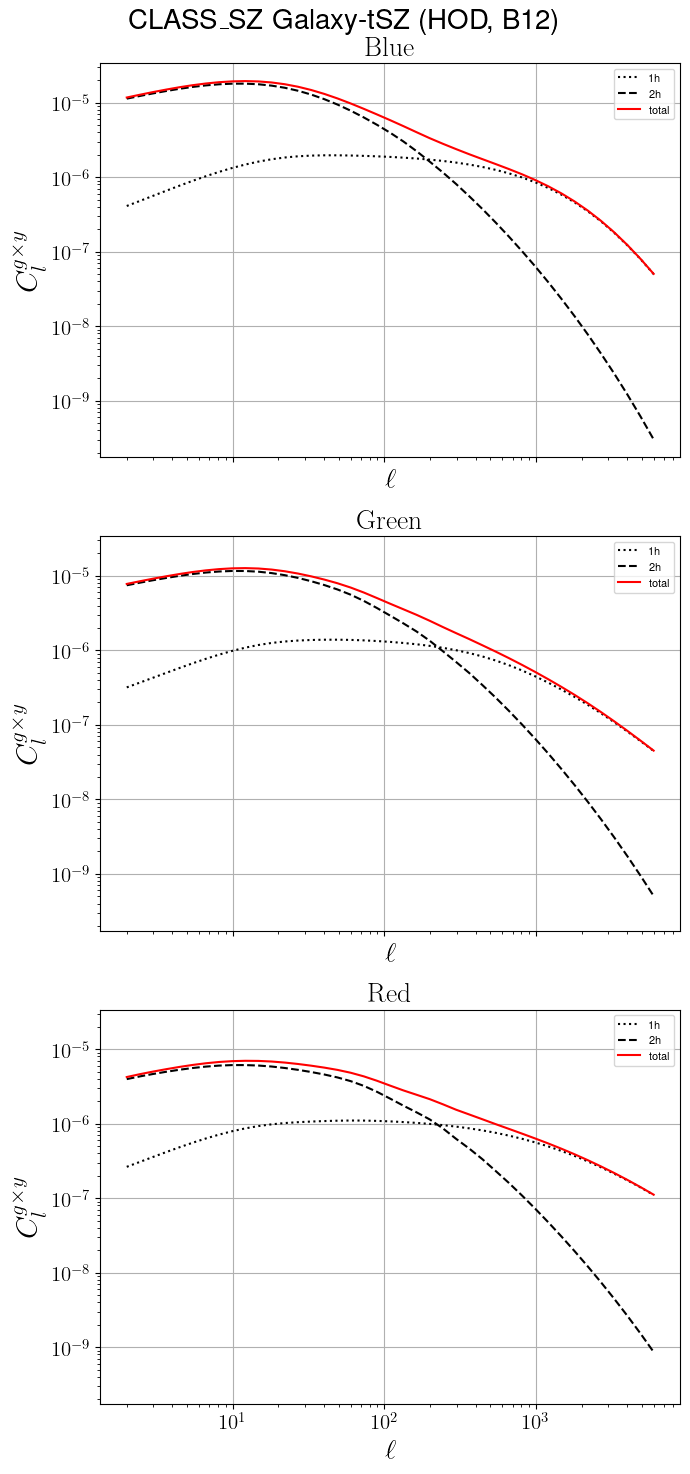

In [15]:
plot_dim = len(cl_galn_tsz.keys())
fig, axes = plt.subplots(figsize=(7, 15), 
                         sharex=True, 
                         sharey=True, 
                         nrows=plot_dim
                         )
plt.subplots_adjust(#left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.4,
                    hspace=0.4)
# x = np.linspace(0, 10, 100)
ik = 0
for i in range(plot_dim):
    kk = list(cl_galn_tsz.keys())[ik]
    strp = list(cl_galn_tsz.keys())[ik]
    kt = dict_names[strp.split('x')[0]]
    ik+=1
    # axes[i, j].plot(x, np.sin((i+j) *x))
    axes[i].tick_params(axis='both', which='major', labelsize=15)
    axes[i].set_title(kt,size=20)
    axes[i].set_xlabel(r"$\ell$",fontsize=20)
    axes[i].set_ylabel(r"$C_l^{g \times y}$",fontsize=22)

    axes[i].grid()
    
    cl = cl_galn_tsz[kk]
    fac = np.asarray(cl['ell'])*(np.asarray(cl['ell'])+1.)/2./np.pi

    axes[i].loglog(cl['ell'],np.asarray(cl['1h'])/fac,":",color ='black',label=r'1h')
    axes[i].loglog(cl['ell'],np.asarray(cl['2h'])/fac,"--",color ='black',label=r'2h')
    axes[i].loglog(cl['ell'],(np.asarray(cl['1h'])+np.asarray(cl['2h']))/fac,color ='red',label=r'total')
    axes[i].legend(loc=1,fontsize=8)
    
fig.suptitle('CLASS_SZ Galaxy-tSZ (HOD, B12)',fontsize=20)
fig.tight_layout()
# plt.savefig('../../notebooks/class_sz_tutorial_notebooks/figures/class_sz_unwise_hod_gkcmb.pdf')